# Simulation of a Single-Server Queue with Impatient Customers

This notebook simulates a banking queue system using the `simpy` library, focusing on a scenario with **impatient customers** (a behavior known in queuing theory as **reneging**).

The simulation models a high-traffic environment where the arrival rate exceeds the service rate, causing queues to build up. Customers have a finite patience level; if they are not served within a specific timeframe, they leave the queue without receiving service.

The key components of the simulation include:

* **Impatient Customer**: Represents a customer who arrives with a specific **patience limit** (10 minutes). They will wait for the teller, but if their wait time exceeds their patience, they leave the bank immediately.
* **Teller**: Represents the single server processing customers.
* **Bank**: Manages the arrival of customers and the interaction between the customers' patience and the teller's availability.

## System Parameters

The system is defined by the following parameters:

* **Arrival Rate ($\lambda$):** 5 customers per minute (Inter-arrival time $\approx 0.2$ mins).
* **Mean Service Time ($E[S]$):** 6 minutes (exponentially distributed).
* **Patience Limit ($T_{renege}$):** 10 minutes.

## Objectives

We aim to measure and analyze the behavior of the queue under pressure. The specific performance metrics for this exercise are:

1.  **Average number of customers in the queue ($E[Q]$):** The average length of the line over the duration of the simulation.
2.  **Reneging Rate:** The average number (or percentage) of customers who leave the bank without being served due to impatience.
3.  **Wait time analysis:**
    * Average wait time for customers who got **served**.
    * Average time spent in the system by customers who **left early**.


In [39]:
from __future__ import annotations

import random
from collections import defaultdict
from collections.abc import Generator
from typing import Any, NoReturn

import matplotlib.pyplot as plt
import simpy
from simpy import Process
from simpy.events import Timeout
from simpy.resources.resource import Release, Request

In [40]:
class Customer:
    def __init__(
        self,
        env: simpy.Environment,
        bank: Bank,
        arrival_time: float,
        service_time: float,
        patience_limit: float,
    ) -> None:
        self.env = env
        self.bank = bank
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time

        self.patience_limit: float = patience_limit

        self.reneged: bool = False
        self.delay: float = 0.0

    def main(self) -> Generator[Request | Process | Any, Any, None]:

        queue_entry_time = self.env.now

        with self.bank.teller.request() as request:

            patience = self.env.timeout(self.patience_limit)

            results = yield request | patience

            if request in results:
                # The customer was served
                self.delay = self.env.now - queue_entry_time

                yield self.env.process(self.bank.teller.process_customer(self))
            else:
                # The customer reneged
                self.reneged = True
                self.delay = self.env.now - queue_entry_time


class Teller(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.queue_history: dict[int, float] = defaultdict(float)
        self.qt = [(0.0, 0)]

        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0

    @property
    def average_queue_length(self) -> float:
        total_time = self.env.now
        if total_time == 0:
            return 0
        weighted_sum = sum(
            length * duration for length, duration in self.queue_history.items()
        )
        return weighted_sum / total_time

    def _update_queue_history(self, _) -> None:
        time_since_last_change = self.env.now - self.last_queue_level_timestamp
        self.queue_history[self.last_queue_level] += time_since_last_change

        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self.qt.append((self.env.now, len(self.queue)))

    def request(self) -> Request:
        self._update_queue_history(None)
        return super().request()

    def release(self, request: Request) -> Release:
        self._update_queue_history(None)
        return super().release(request)

    def process_customer(self, customer: Customer) -> Generator[Timeout, None, None]:
        yield self.env.timeout(customer.service_time)


class Bank:
    def __init__(
        self,
        env: simpy.Environment,
        arrival_rate: float,
        avg_service_time: float,
        patience_limit: float,
    ) -> None:
        self.env = env

        self.teller = Teller(env, capacity=1)
        self.arrival_rate = arrival_rate
        self.avg_service_time = avg_service_time
        self.patience_limit = patience_limit

        self.customers: list[Customer] = []

    def run(self) -> Generator[Timeout, Any, NoReturn]:
        while True:
            yield self.env.timeout(self.arrival_rate)

            customer_service_time = random.expovariate(1 / self.avg_service_time)

            customer = Customer(
                env=self.env,
                bank=self,
                arrival_time=self.env.now,
                service_time=customer_service_time,
                patience_limit=self.patience_limit,
            )

            self.customers.append(customer)
            self.env.process(customer.main())

    def print_statistics(self):
        avg_q_len = self.teller.average_queue_length

        # 2. Reneging Statistics
        total_customers = len(self.customers)
        reneged_customers = [c for c in self.customers if c.reneged]
        renege_count = len(reneged_customers)
        renege_rate = (
            (renege_count / total_customers) * 100 if total_customers > 0 else 0
        )

        print("-" * 30)
        print(f"Simulation Duration: {self.env.now / (60 * 24):.2f} days")
        print(f"Total Customers: {total_customers}")
        print("-" * 30)
        print(f"1. Avg Queue Length: {avg_q_len:.4f} customers")
        print(f"2. Reneged Customers: {renege_count} ({renege_rate:.2f}%)")
        print("-" * 30)

In [41]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env,
    arrival_rate=5,
    avg_service_time=6,
    patience_limit=10,
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # 10 days
bank.print_statistics()

------------------------------
Simulation Duration: 10.00 days
Total Customers: 2879
------------------------------
1. Avg Queue Length: 0.9238 customers
2. Reneged Customers: 731 (25.39%)
------------------------------


In [42]:
class SystemVisualizer:
    def __init__(self, bank: Bank):
        self.bank = bank
        self.customers = bank.customers
        self.teller = bank.teller

    def plot_all(self):
        """Generates a dashboard of 3 plots."""
        fig = plt.figure(figsize=(14, 10))
        gs = fig.add_gridspec(2, 2)

        # 1. Queue Length Over Time
        ax1 = fig.add_subplot(gs[0, :])  # Span full width
        self._plot_queue_over_time(ax1)

        # 2. Wait Time Distribution
        ax2 = fig.add_subplot(gs[1, 0])
        self._plot_wait_time_distribution(ax2)

        # 3. Customer Status (Pie Chart)
        ax3 = fig.add_subplot(gs[1, 1])
        self._plot_customer_status(ax3)

        plt.tight_layout()
        plt.show()

    def _plot_queue_over_time(self, ax):
        """Plot Q(t): Queue length evolution."""

        times, lengths = zip(*self.teller.qt)

        ax.step(times, lengths, where="post", color="#1f77b4", linewidth=1.5)
        ax.fill_between(times, lengths, step="post", alpha=0.3, color="#1f77b4")
        ax.set_title("Queue Length Over Time ($Q(t)$)", fontsize=14)
        ax.set_ylabel("Customers in Queue")
        ax.set_xlabel("Simulation Time (minutes)")
        ax.grid(True, alpha=0.3)

        # Add a line for average
        avg_q = self.teller.average_queue_length
        ax.axhline(avg_q, color="r", linestyle="--", label=f"Avg Q: {avg_q:.2f}")
        ax.legend()

    def _plot_wait_time_distribution(self, ax):
        """Histogram of wait times for Served vs Reneged."""
        served_waits = [c.delay for c in self.customers if not c.reneged]
        reneged_waits = [c.delay for c in self.customers if c.reneged]

        ax.hist(
            [served_waits, reneged_waits],
            bins=20,
            stacked=True,
            color=["#2ca02c", "#d62728"],
            label=["Served", "Reneged"],
            edgecolor="black",
            alpha=0.7,
        )
        ax.set_title("Wait Time Distribution", fontsize=14)
        ax.set_xlabel("Time Spent Waiting (mins)")
        ax.set_ylabel("Count of Customers")
        ax.legend()

        # Mark the patience limit
        ax.axvline(
            self.bank.patience_limit,
            color="k",
            linestyle="--",
            linewidth=1,
            label="Patience Limit",
        )

    def _plot_customer_status(self, ax):
        """Pie chart of Served vs Reneged."""
        total = len(self.customers)
        reneged_count = sum(1 for c in self.customers if c.reneged)
        served_count = total - reneged_count

        labels = [f"Served\n({served_count})", f"Reneged\n({reneged_count})"]
        sizes = [served_count, reneged_count]
        colors = ["#2ca02c", "#d62728"]  # Green for served, Red for reneged

        ax.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            colors=colors,
            wedgeprops={"edgecolor": "white"},
        )
        ax.set_title("Customer Fate", fontsize=14)

    def plot_detailed_analysis(self):
        """Generates clearer plots for long simulations."""
        fig = plt.figure(figsize=(15, 6))
        gs = fig.add_gridspec(1, 2)

        # PLOT 1: Zoomed-in Queue Evolution (First 60 minutes only)
        ax1 = fig.add_subplot(gs[0, 0])
        
        # Get data
        times, lengths = zip(*self.teller.qt)
        
        # Filter for the first 60 minutes
        zoom_limit = 60
        times_zoom = [t for t in times if t <= zoom_limit]
        lengths_zoom = lengths[:len(times_zoom)]

        ax1.step(times_zoom, lengths_zoom, where='post', color='#1f77b4', linewidth=2)
        ax1.fill_between(times_zoom, lengths_zoom, step='post', alpha=0.3, color='#1f77b4')
        ax1.set_title(f"Queue Dynamics (First {zoom_limit} mins only)", fontsize=14)
        ax1.set_ylabel("Customers in Queue")
        ax1.set_xlabel("Simulation Time (minutes)")
        ax1.grid(True, alpha=0.3)
        
        # Mark integers on Y axis because you can't have 1.5 people
        ax1.set_yticks(range(0, int(max(lengths_zoom)) + 2))

        # PLOT 2: Queue State Probability (Histogram)
        ax2 = fig.add_subplot(gs[0, 1])
        
        # We need to weigh the queue lengths by how long they lasted
        # (A queue of length 0 for 10 mins is 'more' than length 5 for 1 sec)
        unique_lengths = sorted(list(set(lengths)))
        durations = []
        
        # Calculate total duration for each queue length state
        state_durations = defaultdict(float)
        for i in range(1, len(times)):
            dt = times[i] - times[i-1]
            state = lengths[i-1]
            state_durations[state] += dt
            
        # Normalize to percentages
        total_time = times[-1]
        probs = [state_durations[k]/total_time * 100 for k in unique_lengths]
        
        bars = ax2.bar(unique_lengths, probs, color='orange', edgecolor='black', alpha=0.7)
        ax2.set_title("Probability of Queue Lengths", fontsize=14)
        ax2.set_xlabel("Number of People in Queue")
        ax2.set_ylabel("Time spent in this state (%)")
        ax2.set_xticks(unique_lengths)
        
        # Add labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

## Results & Visualization

To understand the dynamics of the overloaded banking system, we visualize three key aspects:

1.  **Queue Evolution ($Q(t)$)**:
    We plot the number of customers in the queue over time. Since the arrival rate ($\lambda=5$) is much higher than the service rate ($\mu \approx 0.16$), the system is unstable. We expect to see the queue grow rapidly until it stabilizes purely due to customers leaving (reneging), not because the teller catches up.

2.  **Wait Time Distribution**:
    We compare the wait times of customers who were **served** versus those who **reneged**.

      * **Served Customers**: Their wait time is determined by the queue length when they arrived.
      * **Reneged Customers**: Their wait time should cluster tightly around the patience limit (10 minutes).

3.  **Customer Fate (Served vs. Reneged)**:
    A breakdown of the total customer base to see exactly what proportion of customers are being lost due to the system's inability to keep up with demand.


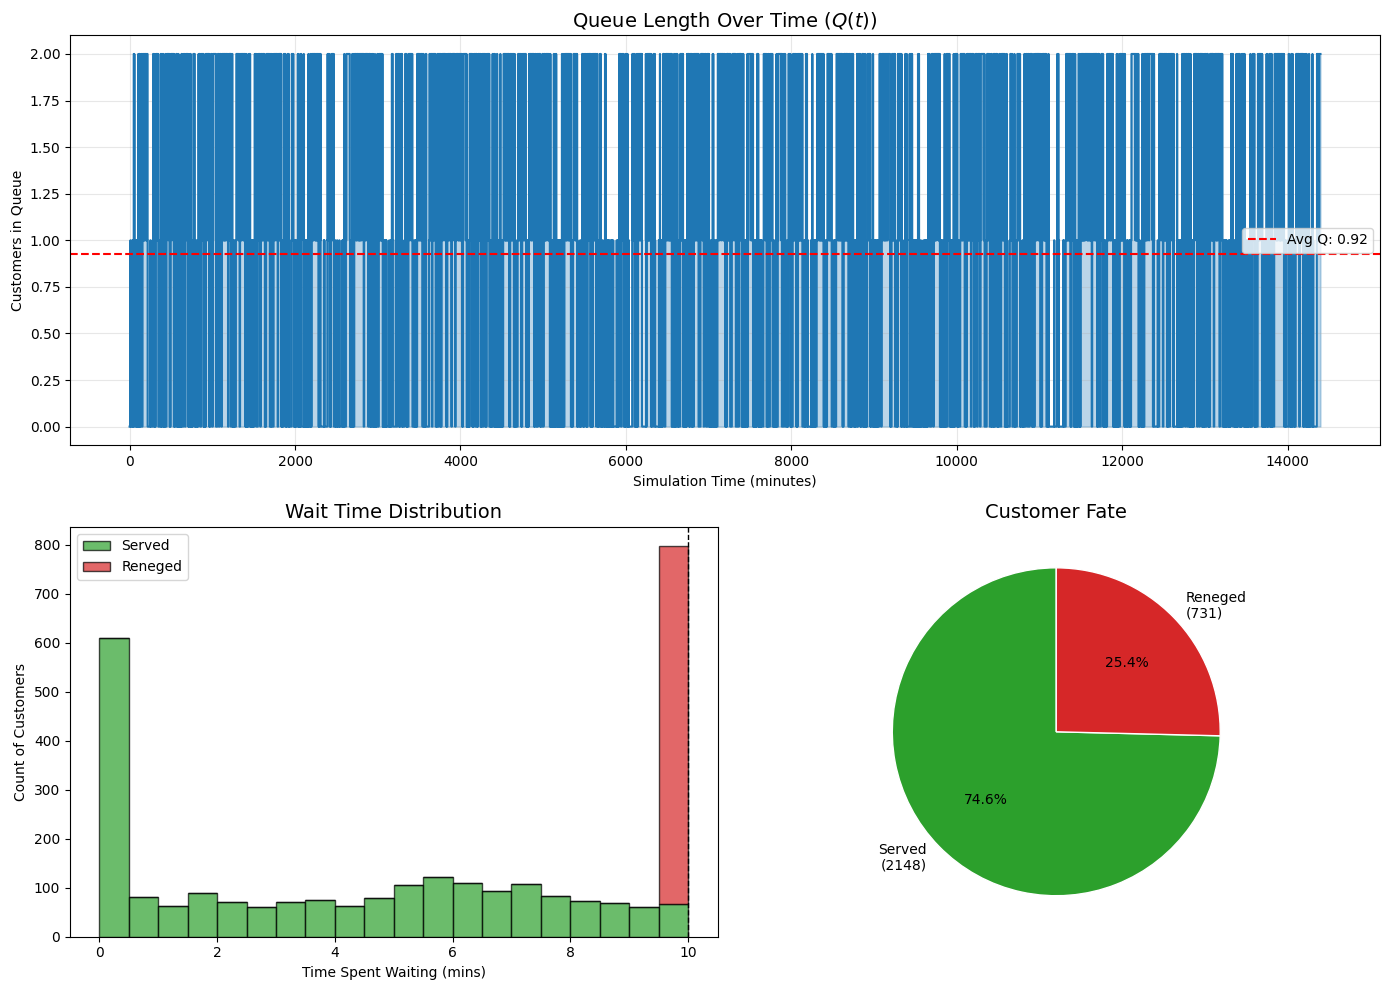

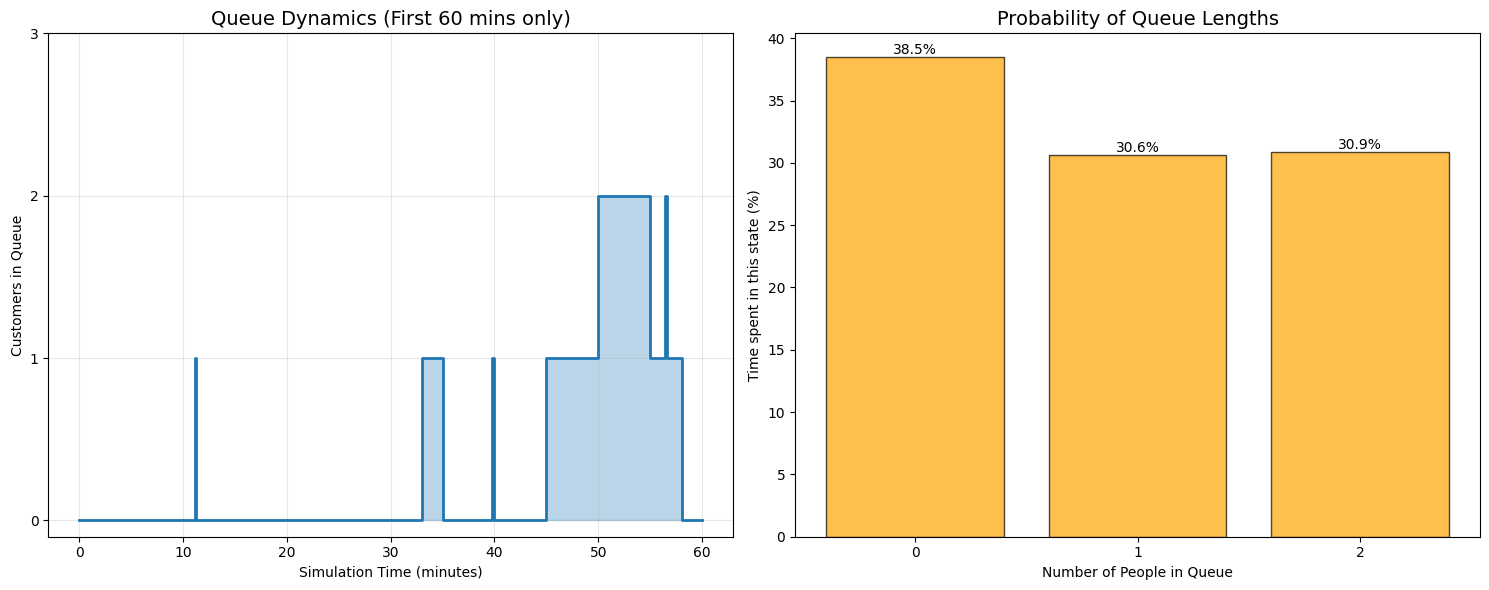

In [43]:
viz = SystemVisualizer(bank)
viz.plot_all()
viz.plot_detailed_analysis()